# 1. Importación de librerías y carga de datos

In [ ]:
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive

import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
import random
import scipy
import time
import os

from shapely import geometry
import geopy
import geopy.distance
import math

import matplotlib.pyplot as plt

from codecarbon import EmissionsTracker

import warnings
warnings.filterwarnings('ignore')

In [ ]:
tf.keras.backend.set_floatx('float64')

In [ ]:
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
DATASETS_FOLDER = os.path.join("TFM", "implementation", "datasets")
POSITIONS_FILE = os.path.join(DATASETS_FOLDER, "positions.csv")
df = pd.read_csv(POSITIONS_FILE)

columns = ['time(s)', 'vehicle_id', 'latitude(m)', 'longitude(m)', 'heading']
df = df[columns]
df = df.sort_values(by=['vehicle_id', 'time(s)'])
df.head()

,time(s),vehicle_id,latitude(m),longitude(m),heading
1063,11.0,2,41.391721,2.162130,43.871783
1168,12.0,2,41.391790,2.162216,43.871783
1273,13.0,2,41.391775,2.162315,124.611142
1378,14.0,2,41.391727,2.162396,131.690664
1483,15.0,2,41.391681,2.162464,133.978174


In [ ]:
# Load fitted model
MODEL_FOLDER = os.path.join("TFM", "implementation", "models", "scaled",
                            "simple", "LSTM_64units")
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE)

In [ ]:
# Load testing data
DATASET_TEST = os.path.join(DATASETS_FOLDER,
                            "ventanas_no_coincidentes_test_scaled.npz")
npzfile = np.load(DATASET_TEST)
X_test = npzfile['X_test']
y_test = npzfile['y_test']
print("X_test: {}  y_test: {}".format(X_test.shape, y_test.shape))

# Load testing vehicle ids list
VEHICLE_IDS_FILE = os.path.join(DATASETS_FOLDER, "vehicle_ids.pkl")
with open(VEHICLE_IDS_FILE, 'rb') as f_vehicle_ids:
  vehicle_ids = pickle.load(f_vehicle_ids)
print("Vehicle_ids: {}".format(len(vehicle_ids)))

X_test: (2584, 20, 3)  y_test: (2584, 5, 3)
Vehicle_ids: 2584


Exception ignored in: <function NpzFile.__del__ at 0x7fe19e77e5e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py", line 224, in __del__
  File "/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py", line 219, in close
OSError: [Errno 107] Transport endpoint is not connected


In [ ]:
# Load MinMaxScaler for target variables
MINMAXSCALER_FILE = os.path.join("TFM", "implementation",
                            "data_preparation", "minmaxscaler.pkl")
with open(MINMAXSCALER_FILE, 'rb') as f_minmaxscaler:
  minmaxscaler = pickle.load(f_minmaxscaler)

In [ ]:
# Load dataset with vehicles dimensions
DATASET_DIM = os.path.join(DATASETS_FOLDER, "dimensions.csv")
df_dim = pd.read_csv(DATASET_DIM)
df_dim = df_dim[['vehicle_id', 'length', 'width']]
df_dim.head()

,vehicle_id,length,width
0,2,5.0,1.8
1,3,5.0,1.8
2,4,2.2,0.9
3,5,5.0,1.8
4,6,5.0,1.8


In [ ]:
# Load dataset with vehicles colision
DATASET_COL = os.path.join(DATASETS_FOLDER, "collisions_1k.csv")
df_col = pd.read_csv(DATASET_COL)
df_col = df_col[['vehicle_id', 'victim_id']].astype(int)
df_col.head()

,vehicle_id,victim_id
0,2899,2884
1,8351,8507
2,6705,6636
3,7523,7414
4,651,541


In [ ]:
# Load dataset with vehicles no-colision
DATASET_NOCOL = os.path.join(DATASETS_FOLDER, "no_collisions_1k.csv")
df_nocol = pd.read_csv(DATASET_NOCOL)
df_nocol = df_nocol[['v1', 'v2']]
df_nocol.head()

,v1,v2
0,6.0,85.0
1,29.0,61.0
2,38.0,266.0
3,38.0,300.0
4,38.0,315.0


# 2. Cálculo de la probabilidad de colisión

In [ ]:
# To get a rotated rectangle at a bearing, you need to get the points of the the recatangle at that bearing
def get_rotated_points(coordinates, bearing, width, length):
  start = geopy.Point(coordinates)
  width = width/1000
  length = length/1000
  rectlength = geopy.distance.distance(kilometers=length)
  rectwidth = geopy.distance.distance(kilometers=width)
  halfwidth = geopy.distance.distance(kilometers=width/2)
  halflength = geopy.distance.distance(kilometers=length/2)

  pointAB = halflength.destination(point=start, bearing=bearing)
  pointA = halfwidth.destination(point=pointAB, bearing=0 - bearing)
  pointB = rectwidth.destination(point=pointA, bearing=180 - bearing)
  pointC = rectlength.destination(point=pointB, bearing=bearing - 180)
  pointD = rectwidth.destination(point=pointC, bearing=0 - bearing)

  points = []
  for point in [pointA, pointB, pointC, pointD]:
    coords = (point.latitude, point.longitude)
    points.append(coords)

  return points


def get_collision(v1_id, v2_id, v1_coords, v2_coords, dimensions):
  colision = 0

  v1_length = dimensions[dimensions['vehicle_id'] == v1_id].iloc[0, 1]
  v1_width = dimensions[dimensions['vehicle_id'] == v1_id].iloc[0, 2]
  v1_points = get_rotated_points(tuple(v1_coords[:2]), v1_coords[2],
                                 v1_width, v1_length)
  polygon1 = geometry.Polygon(v1_points)

  v2_length = dimensions[dimensions['vehicle_id'] == v2_id].iloc[0, 1]
  v2_width = dimensions[dimensions['vehicle_id'] == v2_id].iloc[0, 2]
  v2_points = get_rotated_points(tuple(v2_coords[:2]), v2_coords[2],
                                 v2_width, v2_length)
  polygon2 = geometry.Polygon(v2_points)

  if polygon1.intersection(polygon2).area > 0.0:
    colision = 1
  
  return colision


def calculate_variance(values):
    # Calculate the mean of the values
    mean = np.mean(values)

    # Calculate the variance by summing the squared differences
    # between each value and the mean, and dividing by the number of values
    variance = np.sum((values - mean) ** 2) / len(values)

    return variance


def calculate_covariance(values1, values2):
    # Calculate the means of the values
    mean1 = np.mean(values1)
    mean2 = np.mean(values2)

    # Calculate the covariance by summing the products of the differences
    # between each pair of values and the means, and dividing by the number of values
    covariance = np.sum((values1 - mean1) * (values2 - mean2)) / len(values1)

    return covariance


def calculate_covariance_matrix(latitudes, longitudes, thetas):
    # Calculate the variance of the coordinates and orientation
    # var_lat = calculate_variance(latitudes) # or np.var(latitudes)
    # var_long = calculate_variance(longitudes) # or np.var(longitudes)
    # var_theta = calculate_variance(thetas)  # or np.var(thetas)
    var_lat = np.var(latitudes)
    var_long = np.var(longitudes)
    var_theta = np.var(thetas)

    # Calculate the covariance between the coordinates and orientation
    cov_latlong = calculate_covariance(latitudes, longitudes)
    cov_lattheta = calculate_covariance(latitudes, thetas)
    cov_longtheta = calculate_covariance(longitudes, thetas)

    # Return the covariance matrix
    return np.array([[var_lat, cov_latlong, cov_lattheta],
                     [cov_latlong, var_long, cov_longtheta],
                     [cov_lattheta, cov_longtheta, var_theta]])


def calculate_pdf(y_pred):
    # Calculate the mean position of the vehicle based on its coordinates and orientation
    mean = [np.mean(y_pred[:, 0]), np.mean(y_pred[:, 1]), np.mean(y_pred[:, 2])]

    # Calculate the covariance matrix of the vehicle's position based on its coordinates and orientation
    covariance = calculate_covariance_matrix(y_pred[:, 0], y_pred[:, 1], y_pred[:, 2])

    # Return the probability density function for the vehicle
    return scipy.stats.multivariate_normal(mean=mean, cov=covariance,
                                           allow_singular=True)


def collision_probability(y_pred1, y_pred2, num_samples=1000):
  # Calculate the probability density function for both vehicles
  pdf1 = calculate_pdf(y_pred1)
  pdf2 = calculate_pdf(y_pred2)

  # Generate random samples for the positions of both vehicles
  samples1 = pdf1.rvs(size=num_samples)
  samples2 = pdf2.rvs(size=num_samples)

  # Calculate the number of samples where the vehicles are closer
  collisions = 0
  for i in range(num_samples):
    # Check if there is collision between the vehicles
    if get_collision(v1_id, v2_id, samples1[i], samples2[i], df_dim):
      collisions += 1

  # Return the fraction of samples where the vehicles collide
  return collisions / num_samples

## 2.1. Análisis de tiempos

In [ ]:
# We use the same vehicles for all tests
v1_id = df_col.iloc[0, 0]
v2_id = df_col.iloc[0, 1]

y_v1 = np.array(df[df['vehicle_id'] == v1_id].iloc[-5:, 2:]).reshape(-1, 3)
y_v2 = np.array(df[df['vehicle_id'] == v2_id].iloc[-5:, 2:]).reshape(-1, 3)

### 2.1.1. 100 muestras

In [ ]:
tracker = EmissionsTracker(log_level="error")
tracker.start()
start = time.time()
collision_prob = collision_probability(y_v1, y_v2, num_samples=100)
total_time = time.time() - start
emissions = tracker.stop()
print("Execution time (s): ", total_time)
print("Emissions (kg): ", emissions)
print("Collision probability: ", collision_prob)

Execution time (s):  0.5770454406738281
Emissions (kg):  4.0435749288904275e-06
Collision probability:  0.2


### 2.1.2. 250 muestras

In [ ]:
tracker = EmissionsTracker(log_level="error")
tracker.start()
start = time.time()
collision_prob = collision_probability(y_v1, y_v2, num_samples=250)
total_time = time.time() - start
emissions = tracker.stop()
print("Execution time (s): ", total_time)
print("Emissions (kg): ", emissions)
print("Collision probability: ", collision_prob)

Execution time (s):  2.954197883605957
Emissions (kg):  2.0672907839632006e-05
Collision probability:  0.176


### 2.1.3 300 muestras

In [ ]:
tracker = EmissionsTracker(log_level="error")
tracker.start()
start = time.time()
collision_prob = collision_probability(y_v1, y_v2, num_samples=300)
total_time = time.time() - start
emissions = tracker.stop()
print("Execution time (s): ", total_time)
print("Emissions (kg): ", emissions)
print("Collision probability: ", collision_prob)

Execution time (s):  1.2606697082519531
Emissions (kg):  8.823394704320758e-06
Collision probability:  0.15666666666666668


### 2.1.3 350 muestras

In [ ]:
tracker = EmissionsTracker(log_level="error")
tracker.start()
start = time.time()
collision_prob = collision_probability(y_v1, y_v2, num_samples=350)
total_time = time.time() - start
emissions = tracker.stop()
print("Execution time (s): ", total_time)
print("Emissions (kg): ", emissions)
print("Collision probability: ", collision_prob)

Execution time (s):  1.4765264987945557
Emissions (kg):  1.0332777506294589e-05
Collision probability:  0.20285714285714285


### 2.1.4. 500 muestras

In [ ]:
tracker = EmissionsTracker(log_level="error")
tracker.start()
start = time.time()
collision_prob = collision_probability(y_v1, y_v2, num_samples=500)
total_time = time.time() - start
emissions = tracker.stop()
print("Execution time (s): ", total_time)
print("Emissions (kg): ", emissions)
print("Collision probability: ", collision_prob)

Execution time (s):  2.020169734954834
Emissions (kg):  1.4134966065969031e-05
Collision probability:  0.196


### 2.1.5. 1000 muestras

In [ ]:
tracker = EmissionsTracker(log_level="error")
tracker.start()
start = time.time()
collision_prob = collision_probability(y_v1, y_v2, num_samples=1000)
total_time = time.time() - start
emissions = tracker.stop()
print("Execution time (s): ", total_time)
print("Emissions (kg): ", emissions)
print("Collision probability: ", collision_prob)

Execution time (s):  3.9943435192108154
Emissions (kg):  2.794079662859227e-05
Collision probability:  0.173


## 2.2. Probabilidad de colisión en el conjunto de datos real

In [ ]:
PREDICT=False
SAMPLES=300

col_array = np.empty((0, 5))

# Vehiculos que coinciden y colisionan
for i in range(df_col.shape[0]):
  v1_id = df_col.iloc[i, 0]
  v2_id = df_col.iloc[i, 1]

  if PREDICT:
    v1_index = vehicle_ids.index(v1_id)
    y_v1 = model.predict(X_test[v1_index].reshape(1, 20, 3), verbose=0)
    y_v1 = minmaxscaler.inverse_transform(y_v1.reshape(-1, 3))
    y_v1 = y_v1.reshape(-1, 3)

    v2_index = vehicle_ids.index(v2_id)
    y_v2 = model.predict(X_test[v2_index].reshape(1, 20, 3), verbose=0)
    y_v2 = minmaxscaler.inverse_transform(y_v2.reshape(-1, 3))
    y_v2 = y_v2.reshape(-1, 3)
  else:
    y_v1 = np.array(df[df['vehicle_id'] == v1_id].iloc[-5:, 2:]).reshape(-1, 3)
    y_v2 = np.array(df[df['vehicle_id'] == v2_id].iloc[-5:, 2:]).reshape(-1, 3)

  start = time.time()
  collision_prob = collision_probability(y_v1, y_v2, num_samples=SAMPLES)
  total_time = time.time() - start
  col_array = np.vstack((col_array,
                         np.array([v1_id, v2_id, total_time, collision_prob, 1])))

# Vehiculos que coinciden pero no colisionan
for i in range(df_nocol.shape[0]):
  v1_id = df_nocol.iloc[i, 0]
  v2_id = df_nocol.iloc[i, 1]

  if PREDICT:
    v1_index = vehicle_ids.index(v1_id)
    y_v1 = model.predict(X_test[v1_index].reshape(1, 20, 3), verbose=0)
    y_v1 = minmaxscaler.inverse_transform(y_v1.reshape(-1, 3))
    y_v1 = y_v1.reshape(-1, 3)

    v2_index = vehicle_ids.index(v2_id)
    y_v2 = model.predict(X_test[v2_index].reshape(1, 20, 3), verbose=0)
    y_v2 = minmaxscaler.inverse_transform(y_v2.reshape(-1, 3))
    y_v2 = y_v2.reshape(-1, 3)
  else:
    y_v1 = np.array(df[df['vehicle_id'] == v1_id].iloc[-5:, 2:]).reshape(-1, 3)
    y_v2 = np.array(df[df['vehicle_id'] == v2_id].iloc[-5:, 2:]).reshape(-1, 3)

  start = time.time()
  collision_prob = collision_probability(y_v1, y_v2, num_samples=SAMPLES)
  total_time = time.time() - start
  col_array = np.vstack((col_array,
                         np.array([v1_id, v2_id, total_time, collision_prob, 0])))

In [ ]:
if PREDICT:
  PROB_FILE = os.path.join(MODEL_FOLDER, "collision_prob.csv")
else:
  PROB_FILE = os.path.join(DATASETS_FOLDER, "collision_prob.csv")

df_collision_prob = pd.DataFrame(
    col_array.reshape(-1, 5),
    columns=['vehicle1', 'vehicle2', 'execution_time', 'probability', 'collision'])
df_collision_prob.to_csv(PROB_FILE, index=False)
df_collision_prob.head()

,vehicle1,vehicle2,execution_time,probability,collision
0,2899.0,2884.0,1.234695,0.143333,1.0
1,8351.0,8507.0,1.205617,0.033333,1.0
2,6705.0,6636.0,1.188167,0.003333,1.0
3,7523.0,7414.0,1.211552,0.076667,1.0
4,651.0,541.0,1.153401,0.150000,1.0


In [ ]:
df_collision_prob[df_collision_prob['collision'] == 0].head()

,vehicle1,vehicle2,execution_time,probability,collision
1000,6.0,85.0,1.175482,0.0,0.0
1001,29.0,61.0,1.178097,0.0,0.0
1002,38.0,266.0,1.217370,0.0,0.0
1003,38.0,300.0,1.158477,0.0,0.0
1004,38.0,315.0,1.181981,0.0,0.0


In [ ]:
collisions = df_collision_prob[df_collision_prob['collision'] == 1]
no_collisions = df_collision_prob[df_collision_prob['collision'] == 0]

print("Probabilidad media de colision para las colisiones: {}"
      .format(np.mean(collisions['probability'])))
print("Probabilidad media de colision para las no-colisiones: {}"
      .format(np.mean(no_collisions['probability'])))

print("Tiempo medio de ejecuion para las colisiones: {}"
      .format(np.mean(collisions['execution_time'])))
print("Tiempo medio de ejecuion para las no-colisiones: {}"
      .format(np.mean(no_collisions['execution_time'])))

Probabilidad media de colision para las colisiones: 0.0789833333333333
Probabilidad media de colision para las no-colisiones: 0.02936666666666666
Tiempo medio de ejecuion para las colisiones: 1.2128014111518859
Tiempo medio de ejecuion para las no-colisiones: 1.2060459921360016


In [ ]:
collisions['probability'].describe()

count    1000.000000
mean        0.078983
std         0.116798
min         0.000000
25%         0.016667
50%         0.040000
75%         0.096667
max         0.983333
Name: probability, dtype: float64

In [ ]:
no_collisions['probability'].describe()

count    1000.000000
mean        0.029367
std         0.090990
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.720000
Name: probability, dtype: float64

In [ ]:
collision_threshold = 0.016

print("Valores por encima de la media en las colisiones: {}"
      .format(len(collisions[collisions['probability'] >= collision_threshold])))
print("Valores por debajo de la media en las colisiones: {}"
      .format(len(collisions[collisions['probability'] < collision_threshold])))

print("Valores por encima de la media en las no-colisiones: {}"
      .format(len(no_collisions[no_collisions['probability'] >= collision_threshold])))
print("Valores por debajo de la media en las no-colisiones: {}"
      .format(len(no_collisions[no_collisions['probability'] < collision_threshold])))

Valores por encima de la media en las colisiones: 754
Valores por debajo de la media en las colisiones: 246
Valores por encima de la media en las no-colisiones: 170
Valores por debajo de la media en las no-colisiones: 830


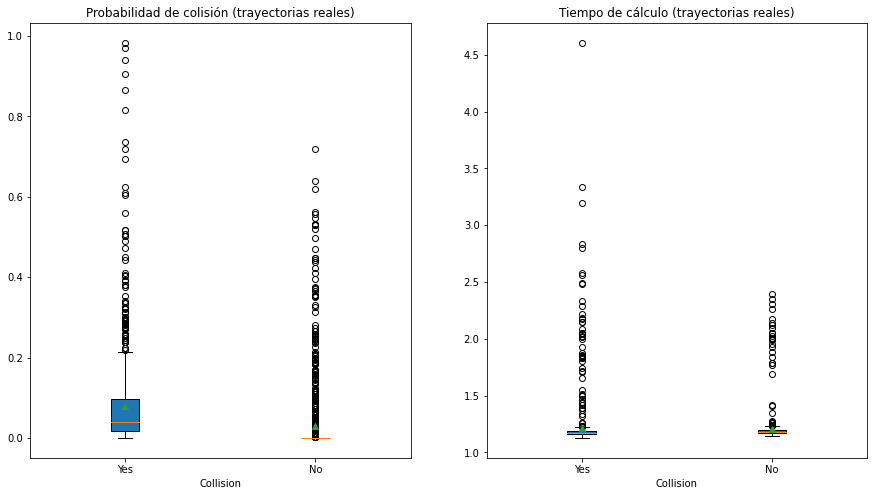

In [ ]:
data_prob = [collisions['probability'], no_collisions['probability']]
data_time = [collisions['execution_time'], no_collisions['execution_time']]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax[0].boxplot(data_prob, showmeans=True, patch_artist = True,
              labels=['Yes', 'No'])
ax[0].set_title("Probabilidad de colisión (trayectorias reales)")
ax[0].set_xlabel("Collision")

ax[1].boxplot(data_time, showmeans=True, patch_artist = True,
              labels=['Yes', 'No'])
ax[1].set_title("Tiempo de cálculo (trayectorias reales)")
ax[1].set_xlabel("Collision")
plt.show()

## 2.3. Probabilidad de colisión en el conjunto de datos predicho

In [ ]:
PREDICT=True
SAMPLES=300

col_array = np.empty((0, 5))

# Vehiculos que coinciden y colisionan
for i in range(df_col.shape[0]):
  v1_id = df_col.iloc[i, 0]
  v2_id = df_col.iloc[i, 1]

  if PREDICT:
    v1_index = vehicle_ids.index(v1_id)
    y_v1 = model.predict(X_test[v1_index].reshape(1, 20, 3), verbose=0)
    y_v1 = minmaxscaler.inverse_transform(y_v1.reshape(-1, 3))
    y_v1 = y_v1.reshape(-1, 3)

    v2_index = vehicle_ids.index(v2_id)
    y_v2 = model.predict(X_test[v2_index].reshape(1, 20, 3), verbose=0)
    y_v2 = minmaxscaler.inverse_transform(y_v2.reshape(-1, 3))
    y_v2 = y_v2.reshape(-1, 3)
  else:
    y_v1 = np.array(df[df['vehicle_id'] == v1_id].iloc[-5:, 2:]).reshape(-1, 3)
    y_v2 = np.array(df[df['vehicle_id'] == v2_id].iloc[-5:, 2:]).reshape(-1, 3)

  start = time.time()
  collision_prob = collision_probability(y_v1, y_v2, num_samples=SAMPLES)
  total_time = time.time() - start
  col_array = np.vstack((col_array,
                         np.array([v1_id, v2_id, total_time, collision_prob, 1])))

# Vehiculos que coinciden pero no colisionan
for i in range(df_nocol.shape[0]):
  v1_id = df_nocol.iloc[i, 0]
  v2_id = df_nocol.iloc[i, 1]

  if PREDICT:
    v1_index = vehicle_ids.index(v1_id)
    y_v1 = model.predict(X_test[v1_index].reshape(1, 20, 3), verbose=0)
    y_v1 = minmaxscaler.inverse_transform(y_v1.reshape(-1, 3))
    y_v1 = y_v1.reshape(-1, 3)

    v2_index = vehicle_ids.index(v2_id)
    y_v2 = model.predict(X_test[v2_index].reshape(1, 20, 3), verbose=0)
    y_v2 = minmaxscaler.inverse_transform(y_v2.reshape(-1, 3))
    y_v2 = y_v2.reshape(-1, 3)
  else:
    y_v1 = np.array(df[df['vehicle_id'] == v1_id].iloc[-5:, 2:]).reshape(-1, 3)
    y_v2 = np.array(df[df['vehicle_id'] == v2_id].iloc[-5:, 2:]).reshape(-1, 3)

  start = time.time()
  collision_prob = collision_probability(y_v1, y_v2, num_samples=SAMPLES)
  total_time = time.time() - start
  col_array = np.vstack((col_array,
                         np.array([v1_id, v2_id, total_time, collision_prob, 0])))

In [ ]:
if PREDICT:
  PROB_FILE = os.path.join(MODEL_FOLDER, "collision_prob.csv")
else:
  PROB_FILE = os.path.join(DATASETS_FOLDER, "collision_prob.csv")

df_collision_prob = pd.DataFrame(
    col_array.reshape(-1, 5),
    columns=['vehicle1', 'vehicle2', 'execution_time', 'probability', 'collision'])
df_collision_prob.to_csv(PROB_FILE, index=False)
df_collision_prob.head()

,vehicle1,vehicle2,execution_time,probability,collision
0,2899.0,2884.0,0.902504,0.00,1.0
1,8351.0,8507.0,0.891165,0.00,1.0
2,6705.0,6636.0,0.896002,0.00,1.0
3,7523.0,7414.0,1.083650,0.00,1.0
4,651.0,541.0,1.104191,0.12,1.0


In [ ]:
collisions = df_collision_prob[df_collision_prob['collision'] == 1]
no_collisions = df_collision_prob[df_collision_prob['collision'] == 0]

print("Probabilidad media de colision para las colisiones: {}"
      .format(np.mean(collisions['probability'])))
print("Probabilidad media de colision para las no-colisiones: {}"
      .format(np.mean(no_collisions['probability'])))

print("Tiempo medio de ejecuion para las colisiones: {}"
      .format(np.mean(collisions['execution_time'])))
print("Tiempo medio de ejecuion para las no-colisiones: {}"
      .format(np.mean(no_collisions['execution_time'])))

Probabilidad media de colision para las colisiones: 0.019973333333333326
Probabilidad media de colision para las no-colisiones: 0.021909999999999995
Tiempo medio de ejecuion para las colisiones: 0.9251557614803314
Tiempo medio de ejecuion para las no-colisiones: 0.9460319805145264


In [ ]:
collision_threshold = 0.016

print("Valores por encima de la media en las colisiones: {}"
      .format(len(collisions[collisions['probability'] >= collision_threshold])))
print("Valores por debajo de la media en las colisiones: {}"
      .format(len(collisions[collisions['probability'] < collision_threshold])))

print("Valores por encima de la media en las no-colisiones: {}"
      .format(len(no_collisions[no_collisions['probability'] >= collision_threshold])))
print("Valores por debajo de la media en las no-colisiones: {}"
      .format(len(no_collisions[no_collisions['probability'] < collision_threshold])))

Valores por encima de la media en las colisiones: 152
Valores por debajo de la media en las colisiones: 848
Valores por encima de la media en las no-colisiones: 87
Valores por debajo de la media en las no-colisiones: 913


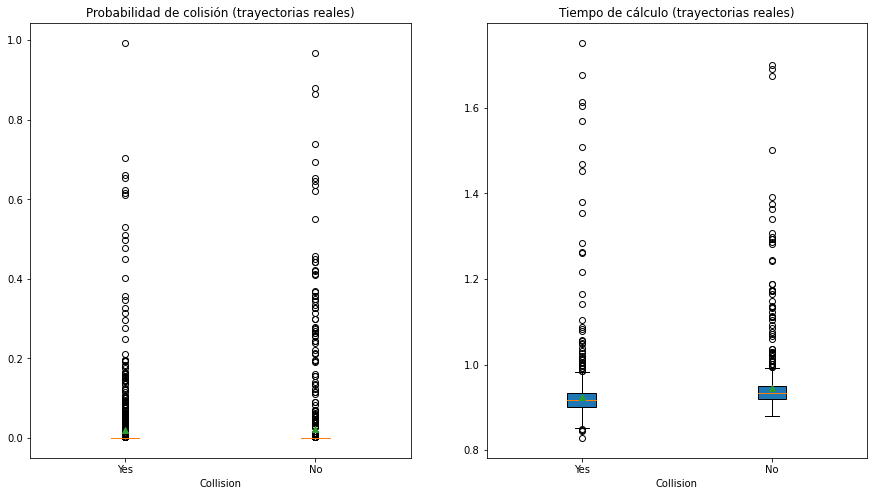

In [ ]:
data_prob = [collisions['probability'], no_collisions['probability']]
data_time = [collisions['execution_time'], no_collisions['execution_time']]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax[0].boxplot(data_prob, showmeans=True, patch_artist = True,
              labels=['Yes', 'No'])
ax[0].set_title("Probabilidad de colisión (trayectorias reales)")
ax[0].set_xlabel("Collision")

ax[1].boxplot(data_time, showmeans=True, patch_artist = True,
              labels=['Yes', 'No'])
ax[1].set_title("Tiempo de cálculo (trayectorias reales)")
ax[1].set_xlabel("Collision")
plt.show()